In [1]:
#import packages internal and external
import tests
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from importlib import reload
import pandas as pd
import datasetBuilder
import tools
import scipy
from sklearn.ensemble import HistGradientBoostingClassifier as hgbc
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import RandomForestClassifier as rfc
import sklearn.base
import pickle
import copy
import tests
from sklearn.metrics import roc_auc_score as auc
import os
import plotAndOrderResults
import datasetBuilder

In [2]:
#Set path variables where we want to save created datasets, intermediate outputs, etc
#If you want to run this on your own computer, obviously you should update the path

outputs_path='/Users/jonahpoczobutt/projects/specsim_res/Metlin_to_Nist_highres'
os.mkdir(outputs_path)


nist14='/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist14_highres.pkl'
gnps='/Users/jonahpoczobutt/projects/raw_data/db_csvs/gnps_highres.pkl'
mona='/Users/jonahpoczobutt/projects/raw_data/db_csvs/mona_highres.pkl'
metlin='/Users/jonahpoczobutt/projects/raw_data/db_csvs/metlin_highres.pkl'

#Set the query and target dbs
#these can be different or the same
query = metlin
target = nist14

#This variable toggles whether we do a full run of the notebook, or if we read in variables created in a previous run
fullRun=True

#create directories for results
if fullRun:
    
    os.mkdir(f'{outputs_path}/intermediateOutputs')
    os.mkdir(f'{outputs_path}/intermediateOutputs/fullSearchMatches')
    os.mkdir(f'{outputs_path}/intermediateOutputs/splitMatches')
    os.mkdir(f'{outputs_path}/intermediateOutputs/quantileDfs')
    os.mkdir(f'{outputs_path}/intermediateOutputs/modelDatasets')
    os.mkdir(f'{outputs_path}/fig1')
    os.mkdir(f'{outputs_path}/fig2')
    os.mkdir(f'{outputs_path}/fig3')
    os.mkdir(f'{outputs_path}/fig4')


Preprocessing: Creating Target and Matches DFs


In [3]:
if fullRun:

    #This should be replaced with a function to read in all the databases
    query_ = pd.read_pickle(query)
    all_bases = list(set(query_['inchi_base']))

    first_bases = all_bases[:int(len(all_bases)*0.7)]
    second_bases = all_bases[int(len(all_bases)/0.7):]

    first_query_ = query_[np.isin(query_['inchi_base'],first_bases)]
    first_query_.reset_index(inplace=True)
    first_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/first_query.pkl')
    del(first_query_)

    second_query_ = query_[np.isin(query_['inchi_base'],first_bases)]
    second_query_.reset_index(inplace=True)
    second_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/second_query.pkl')
    del(second_query_)
    del(query_)

    
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/first_bases.npy',first_bases)
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/second_bases.npy',second_bases)
    del(first_bases)
    del(second_bases)


Figure 1: Global Performance of Individual Metrics/Weighting Schemes

In [4]:
#these are the ppm windows that we want to test
ppm_windows = [10]

#this is the size of the sample we take from the full target
size=800000

#this is the maximum number of matches we allow for each query, based on the precursor window
max_matches=100

#adduct match
adduct_match=False

#Similarity methods and transformation parameters below. Leave sim methods as None to run all
noise_threshes=[0.01,0.05]
centroid_tolerance_vals = [0.05,0.1]
centroid_tolerance_types=['da','da']
powers=[0.25,1,None]
sim_methods=None

if fullRun:
    #we will evaluate the performace of the individual metrics on a large sample from the
    #full target dataset. You can set the size below

    #reload queries and target for individual comparison
    query_=pd.read_pickle(query)
    target_=pd.read_pickle(target)

    #shuffle query to ensure random subset
    query_.sample(frac=1)

    for i in ppm_windows:

        matches = datasetBuilder.create_matches_df_new(query_,target_,i,max_matches,size, adduct_match)
        matches.to_pickle(f'{outputs_path}/intermediateOutputs/fullSearchMatches/matches_{i}_ppm.pkl')

        #comparison on large sample
        tests.create_variable_comparisons(
                                noise_threshes=noise_threshes,
                                centroid_threshes=centroid_tolerance_vals,
                                centroid_types=centroid_tolerance_types,
                                powers=powers,
                                sim_methods=sim_methods,
                                matches=matches,
                                outpath = f'{outputs_path}/fig1/{i}_ppm.csv',
                                )

Figure 2: Assessing Metric Stability in Smaller Samples

In [5]:
#this is the size of the sample we take from the full target
size=2e2

#this is the number of times we want to take a sample of the above size
trials=2

if fullRun:
    #we will evaluate the performace of the individual metrics on a large sample from the
    #full target dataset. You can set the size below

    #reload target
    query_=pd.read_pickle(query)
    target_=pd.read_pickle(target)

    for i in range(trials):

        os.mkdir(f'{outputs_path}/fig2/{i}')
        
        for j in ppm_windows:

            #create matches after shuffling query
            query_ = query_.sample(frac=1)
            matches = datasetBuilder.create_matches_df_new(query_,target_,j,max_matches,size, adduct_match)

            #comparison on small sample
            tests.create_variable_comparisons(
                                    noise_threshes=noise_threshes,
                                    centroid_threshes=centroid_tolerance_vals,
                                    centroid_types=centroid_tolerance_types,
                                    powers=powers,
                                    sim_methods=sim_methods,
                                    matches=matches,
                                    outpath = f'{outputs_path}/fig2/{i}/{j}_ppm.csv'
                                    )

Figures 1 and 2

Top Metrics for 10_ppm.csv by AUC
      0                   1         2                 3
383   8   max_jensenshannon  0.774849  0.01_0.1_da_None
233   8   max_jensenshannon  0.762812  0.01_0.1_da_0.25
401  26    binary_cross_ent  0.762740  0.01_0.1_da_None
425  50         common_mass  0.761166  0.01_0.1_da_None
402  27          lorentzian  0.756922  0.01_0.1_da_None
418  43     max_common_mass  0.756641  0.01_0.1_da_None
445  70           cross_ent  0.754023  0.01_0.1_da_None
420  45  max_bhattacharya_2  0.753459  0.01_0.1_da_None
394  19      bhattacharya_2  0.752895  0.01_0.1_da_None
419  44      bhattacharya_1  0.752895  0.01_0.1_da_None




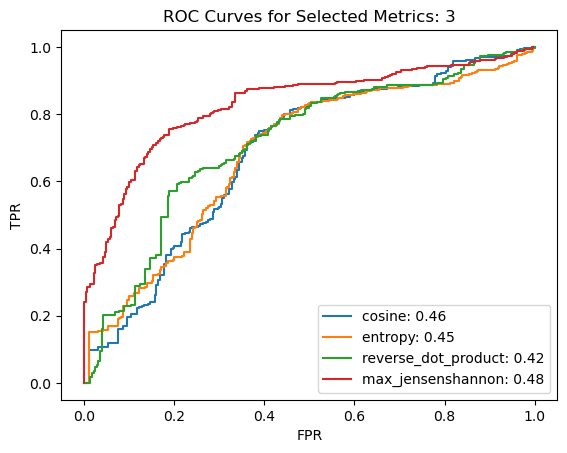

In [6]:
#first, generate tables from full size

reload(tests)
plotAndOrderResults.fig1(f'{outputs_path}/fig1',f'{outputs_path}/intermediateOutputs/fullSearchMatches')


In [7]:
#assess metric stability from small runs
plotAndOrderResults.fig2(f'{outputs_path}/fig2', ppm_windows)

      0                   1         2                 3
880  55  max_bhattacharya_1  0.805328  0.05_0.1_da_None
876  51   max_squared_chord  0.800367  0.05_0.1_da_None
865  40        max_matusita  0.800367  0.05_0.1_da_None
845  20      max_lorentzian  0.797850  0.05_0.1_da_None
730  55  max_bhattacharya_1  0.792242  0.05_0.1_da_0.25
      0                                   1         2                 3
237  12  max_whittaker_index_of_association  0.808971  0.01_0.1_da_0.25
387  12  max_whittaker_index_of_association  0.808743  0.01_0.1_da_None
257  32                       max_cross_ent  0.808515  0.01_0.1_da_0.25
227   2                  max_absolute_value  0.807832  0.01_0.1_da_0.25
248  23                       max_manhattan  0.807832  0.01_0.1_da_0.25
Top Ranks and Means for 10 PPM: Metrics, 75 total
Proportion of Time This Metric is Top
                                index    0
0                  max_bhattacharya_1  0.5
1  max_whittaker_index_of_association  0.5


Mean Ranking 

Figure 3: Hierarchy of Metric Performance Conditional Distributions


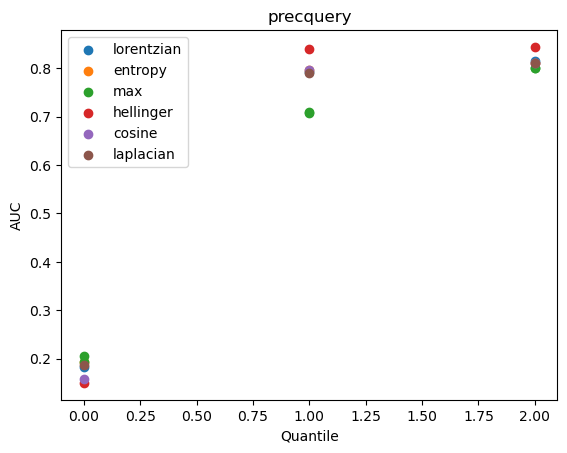

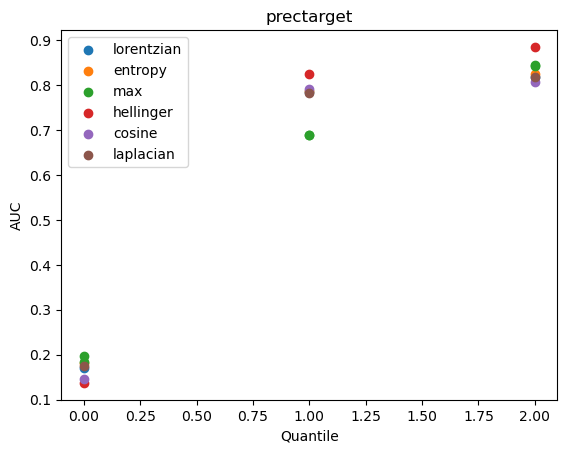

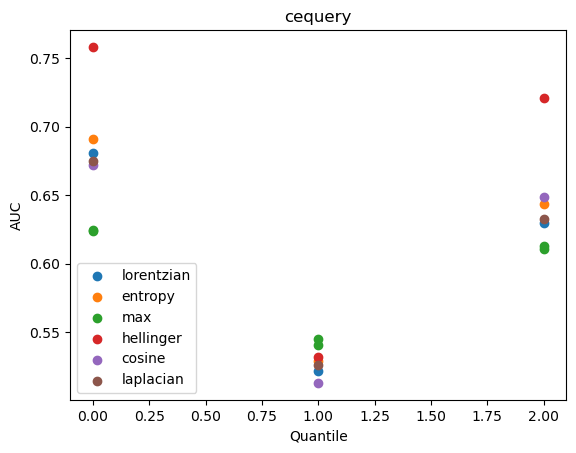

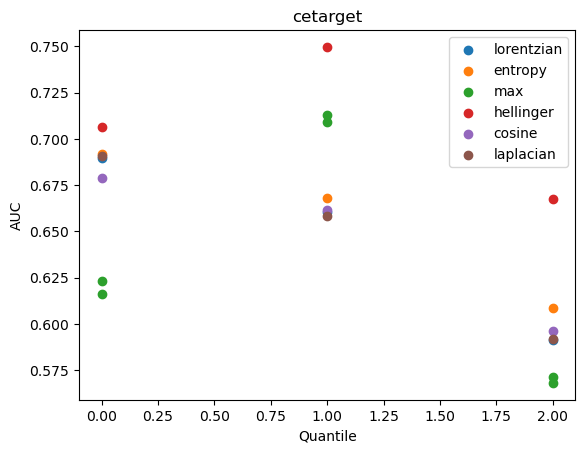

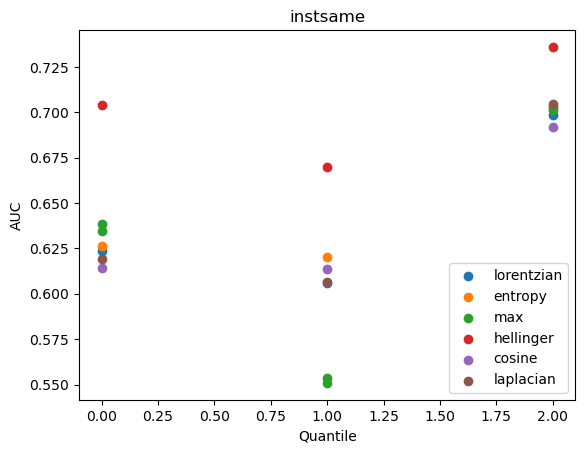

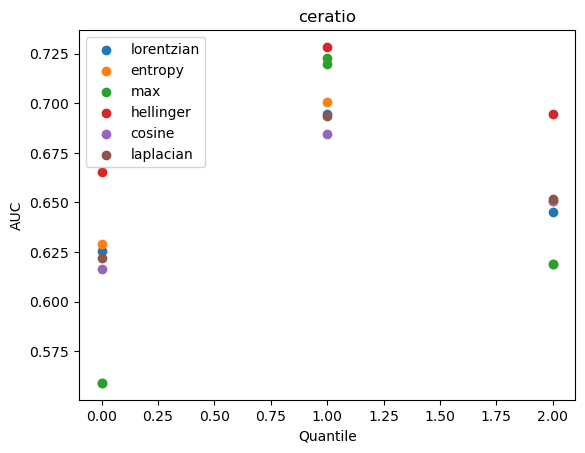

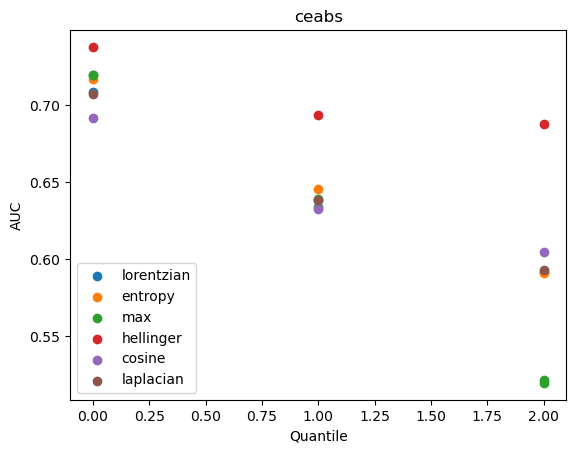

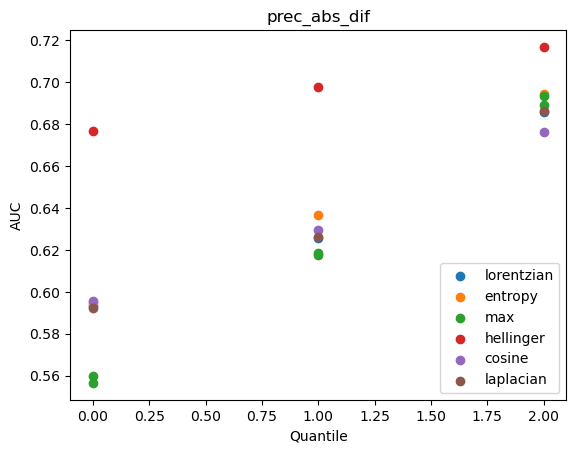

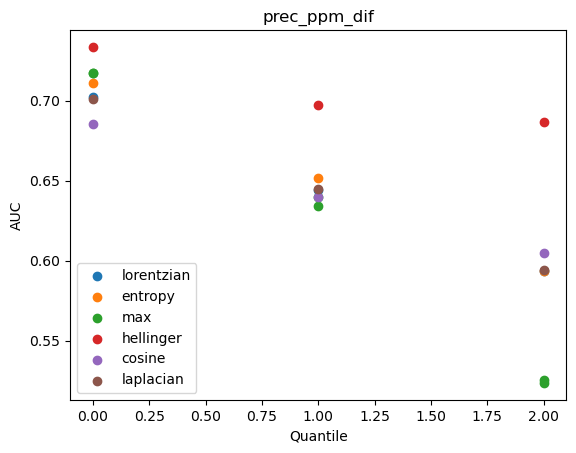

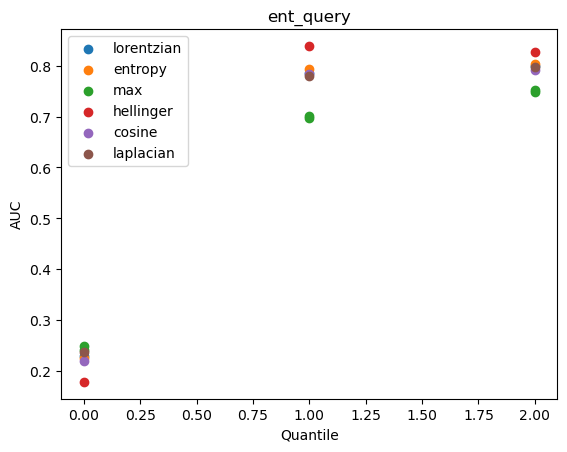

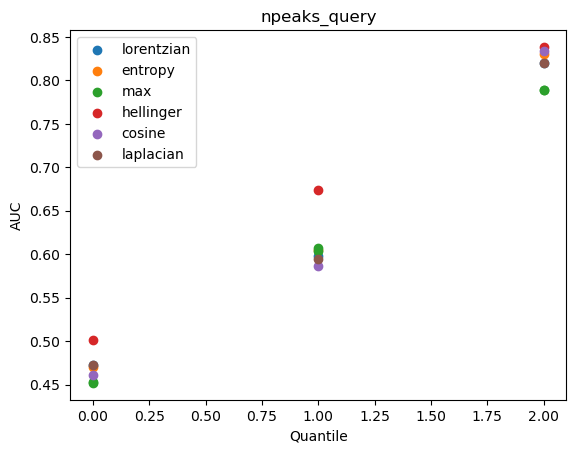

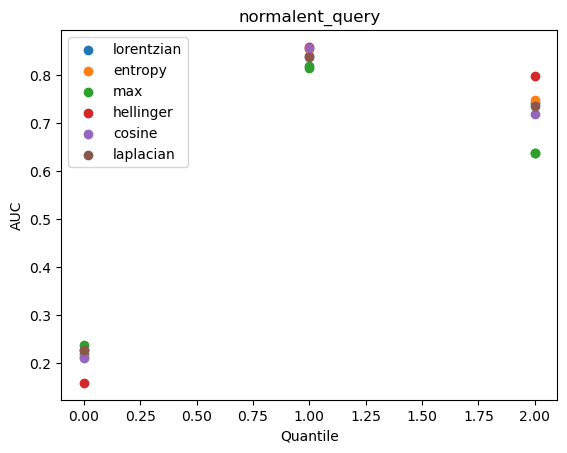

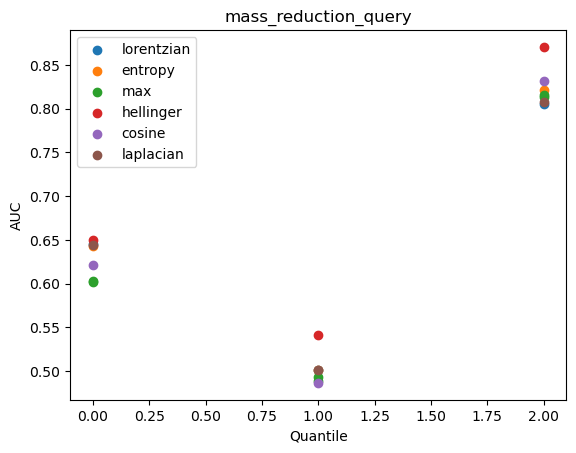

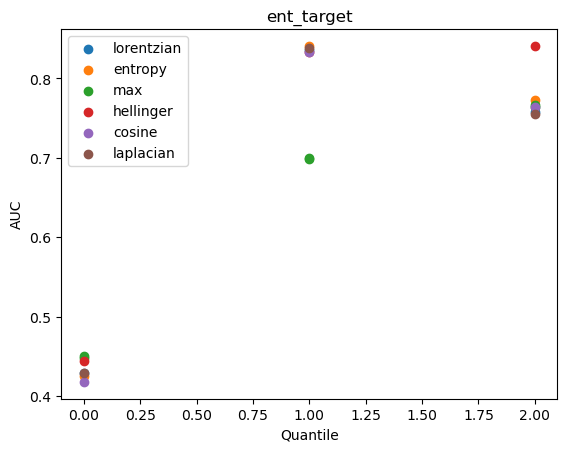

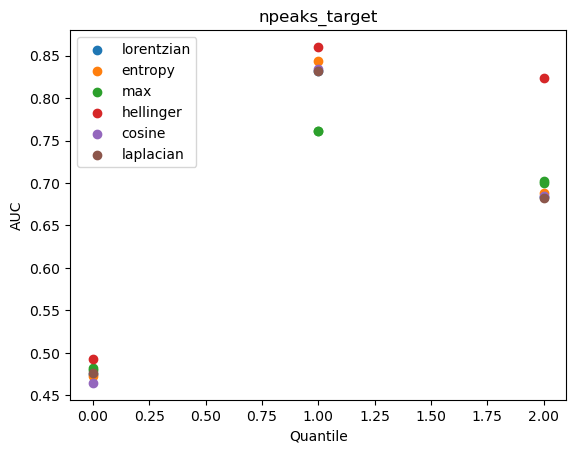

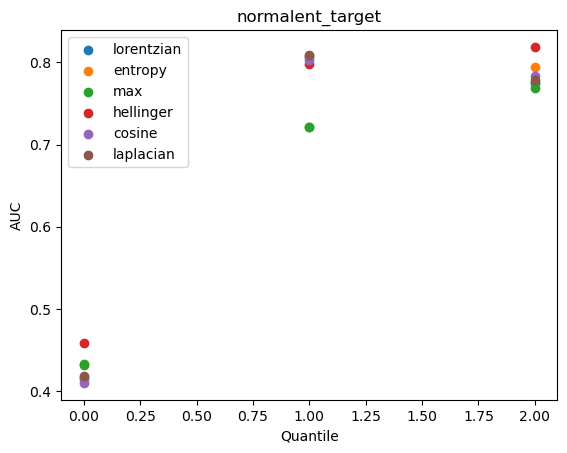

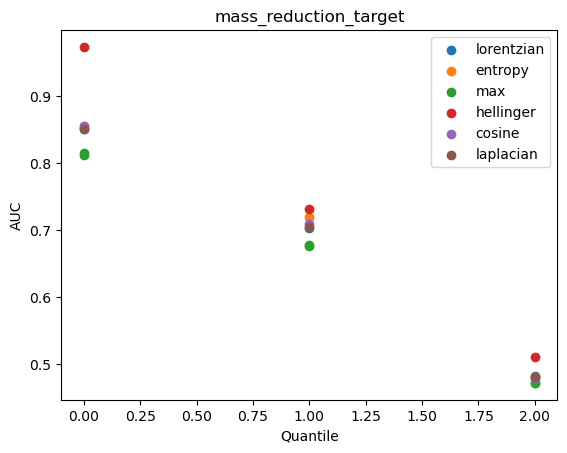

<Figure size 640x480 with 0 Axes>

In [8]:
#we will only consider the default weighting scheme here
#consider all the below metrics
reload(plotAndOrderResults)
reload(tests)
metrics=['lorentzian','lorentzian_jonah','entropy','max_entropy','hellinger','max_bhattacharya_2','cosine','laplacian']
quantile_variables = ['precquery', 'cequery','ceratio','ceabs', 'prec_abs_dif', 'prec_ppm_dif','npeaks_query','normalent_query','ent_query','mass_reduction_query']
quantile_num=3
output_path=f'{outputs_path}/fig3'

for i in ppm_windows:

    matches = pd.read_pickle(f'{outputs_path}/intermediateOutputs/fullSearchMatches/matches_{i}_ppm.pkl')
    input_data = datasetBuilder.create_model_dataset(matches,
                                                     sim_methods=metrics,
                                                     noise_threshes=[0.01],
                                                     centroid_tolerance_vals=[0.05],
                                                     centroid_tolerance_types=["da"],
                                                     powers=[1])

    quantile_variables = input_data.columns[:17]
    metrics = input_data.columns[-len(metrics):-1]
    
    plotAndOrderResults.fig3(input_data, metrics, quantile_variables, quantile_num, output_path)

Figure 4: Combining Features Into Learned Model

First: Create Train and Test datasets for each ppm window

In [58]:
#Similarity methods and transformation parameters below. Leave sim methods as None to run all
noise_threshes=[0.01,0.05,0.1]
centroid_tolerance_vals = [0.05,0.1]
centroid_tolerance_types=['da', 'da']
powers=[0.25,1,3,'ent',None]
sim_methods=['lorentzian','lorentzian_jonah','entropy','max_entropy','hellinger','max_bhattacharya_2']

train_size=1.1e3
test_size=5e2

max_matches=10

target_=pd.read_pickle(target)

for i in ppm_windows:

    #read in first bases and shuffle order
    query_train = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/first_query.pkl')
    query_train=query_train.sample(frac=1)

    #create matches for model to train on
    matches = datasetBuilder.create_matches_df_new(query_train,target_,i,max_matches,train_size, adduct_match)
    del(query_train)

    train = datasetBuilder.create_model_dataset(
                                                matches, 
                                                sim_methods, 
                                                noise_threshes, 
                                                centroid_tolerance_vals, 
                                                centroid_tolerance_types,
                                                powers
                                                )

    print(len(train))
    
    train.to_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/train_{i}_ppm.pkl')
    del(matches)
    del(train)

    #read in test queries and shuffle order
    query_test = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/second_query.pkl')
    query_test=query_test.sample(frac=1)

    #create matches for model to train on
    matches = datasetBuilder.create_matches_df_new(query_test,target_,i,max_matches,test_size, adduct_match)

    del(query_test)

    test = datasetBuilder.create_model_dataset(
                                                matches, 
                                                sim_methods, 
                                                noise_threshes, 
                                                centroid_tolerance_vals, 
                                                centroid_tolerance_types,
                                                powers
                                                )
    
    test.to_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/test_{i}_ppm.pkl')
    matches.to_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/test_{i}_ppm_matches.pkl')
    del(matches)
    del(test)

added 10 settings
added 20 settings
added 30 settings
1102
added 10 settings
added 20 settings
added 30 settings


Then, create the indices we want to test (different features for model)

In [82]:
reload(datasetBuilder)
indices=dict()

noise_threshes=[True,True,True]
centroid_tolerance_values=[True,True]
powers=[True,True,True,True,True]
spec_features=[True,True, True, True, True, True, True, True]#8
sim_methods=[True,True,True,True,True, True]#7

indices['all'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      True,
                                                      True,
                                                      True
                                                    )

indices['all_but_nonspec'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      True,
                                                      False,
                                                      True
                                                    )

indices['nonspec_only']=list(range(9))
indices['nonspec_no_ppm_info']=list(range(2,7))
indices['random_half']=list(np.random.choice(indices['all'][-1], size=int(indices['all'][-1]/2), replace=False))
indices['nonspec_no_precursor']=[2,3,4,5,6]


sim_methods=[False for i in range(6)]#7
indices['no_sims'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      False,
                                                      True,
                                                      True
                                                    )

noise_threshes=[True,True,True]
centroid_tolerance_values=[True,True]
powers=[True,True,True,True,True]
spec_features=[False for i in range(8)]#8
sim_methods=[True for i in range(6)]#7

indices['sims_only'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      False,
                                                      False,
                                                      False,
                                                    )


noise_threshes=[True,True,False]
centroid_tolerance_values=[True,False]
powers=[True,True,False,False,True]
spec_features=[True for i in range(8)]#8
sim_methods=[True,True,False,False,False, False]#7

indices['small_model'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      False,
                                                      True,
                                                      True,
                                                    )


In [83]:
train

,precquery,prectarget,cequery,cetarget,instsame,ceratio,ceabs,prec_abs_dif,prec_ppm_dif,ent_query,...,npeaks_target_0.1_None_0.1da,normalent_target_0.1_None_0.1da,mass_reduction_target_0.1_None_0.1da,lorentzian_0.1_None_0.1da,lorentzian_jonah_0.1_None_0.1da,entropy_0.1_None_0.1da,max_entropy_0.1_None_0.1da,hellinger_0.1_None_0.1da,max_bhattacharya_2_0.1_None_0.1da,match
3,374.2398,374.2398,0.0,12.0,0.0,0.00,12.0,0.0,0.0,2.893973,...,5.0,0.924719,1.0,0.375919,0.106913,0.169874,0.249229,0.093863,0.460061,False
4,374.2398,374.2398,0.0,-1.0,0.0,0.00,1.0,0.0,0.0,2.893973,...,13.0,0.943386,1.0,0.392631,0.193376,0.269081,0.401506,0.090822,0.559343,False
5,374.2398,374.2398,0.0,22.0,0.0,0.00,22.0,0.0,0.0,2.893973,...,11.0,0.928162,1.0,0.374521,0.124036,0.153695,0.309729,0.084218,0.505840,False
6,374.2398,374.2398,0.0,15.0,0.0,0.00,15.0,0.0,0.0,2.893973,...,15.0,0.933696,1.0,0.404283,0.232968,0.261484,0.432265,0.086348,0.579125,False
7,374.2398,374.2398,0.0,24.0,0.0,0.00,24.0,0.0,0.0,2.893973,...,11.0,0.942989,1.0,0.368898,0.104570,0.125384,0.253974,0.081848,0.472448,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,459.0922,459.0922,20.0,25.0,0.0,1.25,5.0,0.0,0.0,2.070949,...,3.0,0.922330,1.0,0.635008,0.666641,0.818326,0.818326,0.374361,0.839039,True
6,459.0922,459.0922,20.0,30.0,0.0,1.50,10.0,0.0,0.0,2.070949,...,3.0,0.920344,1.0,0.635081,0.666665,0.818306,0.818306,0.374351,0.839027,True
7,459.0922,459.0922,20.0,4.0,0.0,5.00,16.0,0.0,0.0,2.070949,...,4.0,0.987106,1.0,0.506930,0.449656,0.507582,0.663922,0.225608,0.725961,True
8,459.0922,459.0922,20.0,23.0,0.0,1.15,3.0,0.0,0.0,2.070949,...,3.0,0.920454,1.0,0.634963,0.666498,0.818948,0.818948,0.374659,0.839417,True


In [85]:
reload(tests)

for i in ppm_windows:
        #import train, val and test
        train = pd.read_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/train_{i}_ppm.pkl')
        test = pd.read_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/test_{i}_ppm.pkl')
        val=train[:100]#int(1e5)]
        train=train[100:]#int(1e5):]

        #hyperparam specifications for models, 
        #we will choose the best performer on val data for each feature subset
        models = [
                hgbc(),
                hgbc(learning_rate=0.01),
                hgbc(learning_rate=0.5),
                hgbc(max_iter=200),
                hgbc(learning_rate=0.01, max_iter=200),
                hgbc(learning_rate=0.5, max_iter=200),
                hgbc(min_samples_leaf=10),
                hgbc(learning_rate=0.01,min_samples_leaf=10),
                hgbc(learning_rate=0.5,min_samples_leaf=10),
                hgbc(max_iter=200,min_samples_leaf=10),
                hgbc(learning_rate=0.01, max_iter=200,min_samples_leaf=10),
                hgbc(learning_rate=0.5, max_iter=200,min_samples_leaf=10),
                ]

        results_by_subset = tests.best_models_by_subset(indices, [int(1e6)], models, train, val, test)

        del(train)
        del(val)

finished all for 1000000
finished all_but_nonspec for 1000000
finished nonspec_only for 1000000
finished nonspec_no_ppm_info for 1000000
finished random_half for 1000000
finished nonspec_no_precursor for 1000000
finished no_sims for 1000000
finished sims_only for 1000000
finished small_model for 1000000


In [86]:
results_by_subset

{'all': [(HistGradientBoostingClassifier(min_samples_leaf=10),
   0.7006232538147431,
   array([0.93860984, 0.91374937, 0.93302892, 0.93759513, 0.92998478,
          0.93099949, 0.95383054, 0.91324201, 0.86960934, 0.95383054,
          0.92947742, 0.8746829 ]))],
 'all_but_nonspec': [(HistGradientBoostingClassifier(max_iter=200),
   0.7479352798501735,
   array([0.920345  , 0.88280061, 0.92592593, 0.92846271, 0.88838153,
          0.92694064, 0.90461695, 0.8173516 , 0.91730086, 0.9086758 ,
          0.84830036, 0.91628615]))],
 'nonspec_only': [(HistGradientBoostingClassifier(learning_rate=0.01, min_samples_leaf=10),
   0.5435356605569371,
   array([0.63901573, 0.59183156, 0.60197869, 0.6217656 , 0.63039066,
          0.59030949, 0.59589041, 0.6463724 , 0.62683917, 0.58726535,
          0.60908168, 0.61567732]))],
 'nonspec_no_ppm_info': [(HistGradientBoostingClassifier(learning_rate=0.01, max_iter=200,
                                  min_samples_leaf=10),
   0.4911270762334592,
   a